This file contains python code to analysis the resutls for comparing with sinica paper

Plz check the work log (on Aug 23, 2023) in notion. 

It is under the linear setting

In [5]:
import sys
sys.path.append("../../mypkg")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from collections import defaultdict as ddict
from tqdm import trange, tqdm
from scipy.io import loadmat
from pprint import pprint
import pandas as pd
import itertools
from scipy.stats import chi2


In [7]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from hdf_utils.utils import gen_lam_seq
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl, get_local_min_idxs
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization
from penalties.scad_pen import SCAD
from models.linear_model import LinearModel

from joblib import Parallel, delayed

In [9]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# fns

In [10]:
def _fname2tuple(fname):
    """From file name to get (seed, lam, N)
    """
    para = list(map(lambda x: float(x.split("_")[-1]), fname.stem.split("-")))
    para[1] = para[1]/1000
    para1 = (para[0], para[1], para[2])
    return para1
def _extract(cur_fil):
    """From file to get mse and mae
    """
    cur_res = load_pkl(cur_fil, verbose=0);
    res = edict()
    res.mse = np.mean(cur_res.cv_errs**2)
    res.pvals = cur_res.pvals
    res.mae = np.mean(np.abs(cur_res.cv_errs))
    res.para = _fname2tuple(cur_fil)
    res.T_vs = cur_res.T_vs
    return res

def _ress2opt(ress, err_type="mse"):
    """Get optimal error and corresponding N, lam and pvals
        input is ress = list(map(_extract, cur_fils));
    """
    min_err = 1000
    opt_pvals = []
    opt_para = None
    for res in ress:
        if res[err_type] < min_err:
            min_err = res[err_type]
            opt_para = res.para
            opt_pvals = res.pvals
    opt_res = edict()
    opt_res.err = min_err
    opt_res.para = opt_para
    opt_res.pvals = opt_pvals
    return opt_res

def _get_min_mat_idx(arr):
    return np.unravel_index(arr.argmin(), arr.shape)

def _get_min_idx(x):
    """Get the index of the minimal values among the local minimals.
       If there are multiple ones, return the largest index
       args:
           x: a vec
        
    """
    x = np.array(x)
    lmin_idxs = get_local_min_idxs(x);
    if len(lmin_idxs) == 0:
        lmin_idxs = np.arange(len(x))
    lmin_idxs_inv =  lmin_idxs[::-1]
    lmins_inv = x[lmin_idxs_inv];
    return  lmin_idxs_inv[np.argmin(lmins_inv)]

# Analysis (pre)

Analysis based on the pre-saved results
You should run `simu_cmp2sinica_pre-ana.ipynb` first

In [74]:
paras = edict()
paras.res_dir = RES_ROOT/"res_bak/simu_linear_sinica_samebetaX_lastbeta02_imp_cvcenter_init0_stable"
paras.can_Ns = [4, 6, 8, 10, 12]

In [75]:
_err_fn = lambda x: np.nanmean(x**2)
#_err_fn = lambda x: np.nanmean(np.abs(x))

def _get_optlam_fixN(res_lams):
    """Get results under optimal lambda for fixed N
    """
    errs = [_err_fn(res_lam.cv_errs) for res_lam in res_lams]
    return res_lams[_get_min_idx(errs)]
    #return res_lams[np.argmin(errs)]

In [76]:
# optimal N and lam
c1_fct = 1000
c1 = 0.4
print("The power/type I error under optimal N and lams")
for c1 in [0, 0.1, 0.2, 0.4]:
    fil = list(paras.res_dir.glob(f"allseeds*-c1_{c1*c1_fct:.0f}.pkl"))[0]
    res_paras = load_pkl(fil, verbose=False).paras;
    
    all_ress = []
    for N in paras.can_Ns:
        fil = list(paras.res_dir.glob(f"allseeds*-N_{N:.0f}-c1_{c1*c1_fct:.0f}.pkl"))[0]
        res = load_pkl(fil, verbose=False)
        res_lam_fixN = [_get_optlam_fixN(tmp) for tmp in res.all_res]
        all_ress.append(res_lam_fixN)
        
    all_errss =  ddict(lambda : np.zeros(len(paras.can_Ns), dtype=float)-1);
    all_pvalss =  ddict(lambda : np.zeros(len(paras.can_Ns), dtype=float)-1);
    all_optlams =  ddict(lambda : np.zeros(len(paras.can_Ns), dtype=float)-1);
    for idx, all_res in enumerate(all_ress):
        for res in all_res:
            all_errss[int(res.seed)][idx] = _err_fn(res.cv_errs)
            all_pvalss[int(res.seed)][idx] = res.pvals[0]
            all_optlams[int(res.seed)][idx] = res.lam
            
    # get error and pval under optimal N and lam.
    opt_errs = []
    opt_pvals = []
    opt_Ns = []
    opt_lams = []
    for k, v  in all_errss.items():
        #if k >= 200:
        #    continue
        pvals = all_pvalss[k]
        if np.sum(v==-1)==0:
            opt_errs.append(np.min(v))
            opt_pvals.append(pvals[np.argmin(v)])
            opt_Ns.append(paras.can_Ns[np.argmin(v)])
            opt_lams.append(all_optlams[k][np.argmin(v)])
    opt_pvals = np.array(opt_pvals)
    opt_errs = np.array(opt_errs);
    opt_lams = np.array(opt_lams);
    opt_Ns = np.array(opt_Ns);
        
    print('-'*100)
    #print(np.unique(opt_Ns, return_counts=1))
    print(f"The power under c1={c1:.2f} and sample size {len(opt_errs):.0f} with CV1 is {np.mean(opt_pvals < 0.05):.3f}.")
    
    opt_lamNs = np.stack([opt_lams, opt_Ns]).T;
    coms, cts  = np.unique(opt_lamNs, axis=0, return_counts=1);
    opt_lam1, opt_N1 = coms[np.argmax(cts)]
    fil = list(paras.res_dir.glob(f"allseeds*-N_{opt_N1:.0f}-c1_{c1*c1_fct:.0f}.pkl"))[0]
    opt_res1 = load_pkl(fil, verbose=False);
    opt_pvals1 = []
    for tmp_res in opt_res1.all_res:
        opt_pvals1.append([tt.pvals[0] for tt in tmp_res if tt.lam==opt_lam1][0])
    opt_pvals1 = np.array(opt_pvals1);
    print(f"The power under c1={c1:.2f} and sample size {len(opt_errs):.0f} with CV2 is {np.mean(opt_pvals1 < 0.05):.3f}.")

The power/type I error under optimal N and lams
----------------------------------------------------------------------------------------------------
The power under c1=0.00 and sample size 200 with CV1 is 0.040.
The power under c1=0.00 and sample size 200 with CV2 is 0.040.
----------------------------------------------------------------------------------------------------
The power under c1=0.10 and sample size 200 with CV1 is 0.140.
The power under c1=0.10 and sample size 200 with CV2 is 0.130.
----------------------------------------------------------------------------------------------------
The power under c1=0.20 and sample size 200 with CV1 is 0.375.
The power under c1=0.20 and sample size 200 with CV2 is 0.440.
----------------------------------------------------------------------------------------------------
The power under c1=0.40 and sample size 200 with CV1 is 0.880.
The power under c1=0.40 and sample size 200 with CV2 is 0.960.


In [24]:
# fixed N and optimal lam
cur_N = 6
df_res = ddict(list)
df_res["c1s"] = [0, 0.1, 0.2, 0.4]
#for cur_N in [6]:
for cur_N in paras.can_Ns:
    #print(f"The power/type I error under optimal lam and N = {cur_N}")
    for c1 in df_res["c1s"]:
        fil = list(paras.res_dir.glob(f"allseeds*N_{cur_N:.0f}-c1_{c1*c1_fct:.0f}.pkl"))[0]
        res_paras = load_pkl(fil, verbose=False).paras;
        
        all_ress = []
        fil = list(paras.res_dir.glob(f"allseeds*-N_{cur_N:.0f}-c1_{c1*c1_fct:.0f}.pkl"))[0]
        res = load_pkl(fil, verbose=False)
        res_lam_fixN = [_get_optlam_fixN(tmp) for tmp in res.all_res];
        
        pvals = np.array([res.pvals[0] for res in res_lam_fixN]);
        df_res[f"N={cur_N}"].append(f"{np.mean(pvals < 0.05):.3f} ({len(pvals):.0f})")
        #print(f"The power under c1={c1:.1f} and sample size {len(pvals):.0f} is {np.mean(pvals < 0.05):.3f}.")
pd.DataFrame(df_res)

,c1s,N=4,N=6,N=8,N=10,N=12
0,0.0,0.050 (200),0.070 (200),0.095 (200),0.110 (200),0.115 (200)
1,0.1,0.565 (200),0.440 (200),0.500 (200),0.515 (200),0.585 (200)
2,0.2,0.980 (200),0.945 (200),0.935 (200),0.955 (200),0.950 (200)
3,0.4,1.000 (200),1.000 (200),1.000 (200),1.000 (200),0.995 (200)


# Results from sinica

In [11]:
sini_paras = edict()
sini_paras = RES_ROOT/"sinica_results/SinicaX_d-200_n-100_test1";

In [12]:
c1 = 0.4
c1_fct = 1000

for c1 in [0.0, 0.1, 0.2, 0.4]:
    all_fils = list(sini_paras.glob(f"c1_{c1*c1_fct:.0f}_*.mat"));
    sorted_all_fils = sorted(all_fils, key=lambda x: int(x.stem.split("_")[3]));
    
    sini_pvals = []
    opt_sns = []
    for fil in sorted_all_fils:
        res = loadmat(fil);
        sini_pvals.append(res["pval"][0][0])
        opt_sns.append(res["opt_sn"][0][0])
    sini_pvals = np.array(sini_pvals);
    opt_sns = np.array(opt_sns);
    print(f"The power under c1={c1:.2f} is {np.mean(sini_pvals < 0.05):.3f}.")

The power under c1=0.00 is 0.048.
The power under c1=0.10 is 0.123.
The power under c1=0.20 is 0.421.
The power under c1=0.40 is 0.935.


In [13]:
np.unique(opt_sns, return_counts=1)

(array([ 1,  4,  7, 10, 13, 16, 19], dtype=uint8),
 array([219, 504, 211,  43,  18,   4,   1]))

# Analysis (backup)

## Fix N and lam

In [8]:
paras.can_lams_trunc, paras.can_Ns

([0.01, 0.1, 0.2, 0.3, 0.4, 0.6, 1.0, 2.0, 8.0], [6, 8, 10, 12, 14, 16])

In [9]:
cur_N = 6
cur_lam = 0.3
cur_fils = list(paras.res_dir.glob(f"seed_*-lam_{cur_lam*1000:.0f}-N_{cur_N:.0f}-c1_2.pkl"));
ress = list(map(_extract, cur_fils));

In [10]:
pvals = np.array([res.pvals[0] for res in ress]);
np.mean(pvals < 0.05)

0.3645833333333333

## Fix N

In [138]:
cur_N = 12
all_fils = list(paras.res_dir.glob(f"seed*N_{cur_N:.0f}-c1_4.pkl"));
all_fils.sort(key=_fname2tuple)

In [139]:
all_seeds = sorted(list(set(map(lambda x: int(_fname2tuple(x)[0]), all_fils))));
opt_ress_N = []
for cur_seed in tqdm(all_seeds):
    cur_fils = list(paras.res_dir.glob(f"seed_{cur_seed:.0f}-*N_{cur_N:.0f}-c1_4.pkl"));
    cur_fils.sort(key=_fname2tuple)
    if len(cur_fils) < len(paras.can_lams):
        continue
        
    ress = list(map(_extract, cur_fils));
    opt_res = _ress2opt(ress);
    opt_ress_N.append(opt_res)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [02:46<00:00,  2.77s/it]


In [140]:
pvals = np.array([opt_res.pvals[0] for opt_res in opt_ress_N]);
np.mean(pvals<0.05)

0.5254237288135594

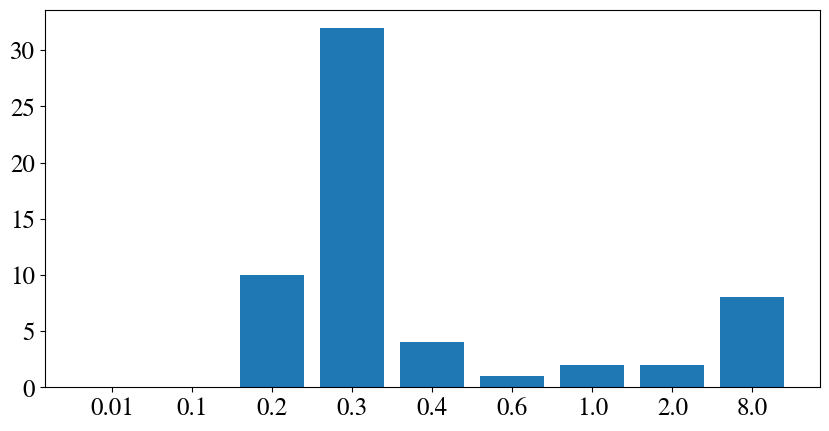

In [141]:
sel_lams = [opt_res.para[1] for opt_res in opt_ress_N];
vs, cts = np.unique(sel_lams, return_counts=1);
cts_full = np.zeros(len(paras.can_lams))
for ix, cur_v in enumerate(paras.can_lams_trunc):
    if np.sum(vs==cur_v) == 0:
        continue
    cts_full[ix] = cts[vs==cur_v][0]
plt.bar(np.arange(len(paras.can_lams_trunc)), cts_full)
plt.xticks(np.arange(len(paras.can_lams_trunc)), paras.can_lams_trunc);

## Opt N and lam for CV

In [48]:
all_fils = list(paras.res_dir.glob("seed*-c1_2.pkl"));
all_fils.sort(key=_fname2tuple)

In [ ]:
all_seeds = sorted(list(set(map(lambda x: int(_fname2tuple(x)[0]), all_fils))));
opt_ress = []
for cur_seed in tqdm(all_seeds):
    cur_fils = list(paras.res_dir.glob(f"seed_{cur_seed:.0f}-*-c1_2.pkl"));
    cur_fils.sort(key=_fname2tuple)
    if len(cur_fils) < (len(paras.can_Ns)*len(paras.can_lams)):
        continue
        
    ress = list(map(_extract, cur_fils));
    opt_res = _ress2opt(ress);
    opt_ress.append(opt_res)
    

 66%|███████████████████████████████████████████████████████████████████████████████████████████▏                                              | 37/56 [10:19<05:17, 16.72s/it]

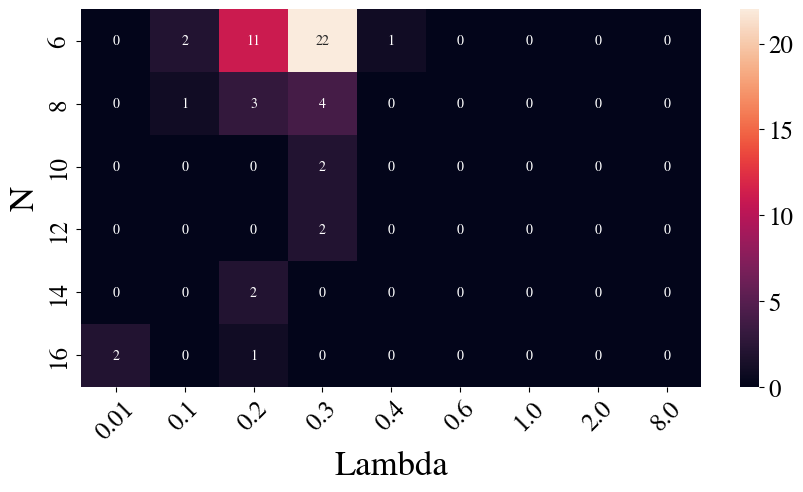

In [42]:
ct_mat = np.zeros((len(paras.can_Ns), len(paras.can_lams_trunc)));
for opt_res in opt_ress:
    row_ix = paras.can_Ns.index(opt_res.para[2])
    col_ix = paras.can_lams_trunc.index(opt_res.para[1])
    ct_mat[row_ix, col_ix] = ct_mat[row_ix, col_ix] +1 
                        
if True:
    sns.heatmap(ct_mat, annot=ct_mat, fmt='.0f',  annot_kws={"size": 10})
    plt.yticks(np.arange(ct_mat.shape[0])+0.5, paras.can_Ns)
    plt.xticks(np.arange(ct_mat.shape[1])+0.5, paras.can_lams_trunc, rotation=45);
    plt.ylabel("N")
    plt.xlabel("Lambda")

In [43]:
pvals = np.array([opt_res.pvals[0] for opt_res in opt_ress]);
np.mean(pvals < 0.05)

0.09433962264150944

In [47]:
for opt_res in opt_ress:
    if opt_res.pvals[0] > 0.05:
        print(opt_res)

{'err': 1.0872078420692186, 'para': [0.0, 0.3, 6.0], 'pvals': [0.9177966379495134]}
{'err': 1.0083399513900189, 'para': [1.0, 0.2, 6.0], 'pvals': [0.43333113272200896]}
{'err': 1.1982759160168013, 'para': [2.0, 0.3, 6.0], 'pvals': [0.5013977736223236]}
{'err': 1.114012843435709, 'para': [3.0, 0.2, 16.0], 'pvals': [0.9722796476723616]}
{'err': 1.1903758677878296, 'para': [4.0, 0.1, 8.0], 'pvals': [0.9999528300785802]}
{'err': 1.0969208142672464, 'para': [5.0, 0.2, 6.0], 'pvals': [0.9477839474568772]}
{'err': 1.3604780596652732, 'para': [6.0, 0.3, 6.0], 'pvals': [0.8813596874697929]}
{'err': 0.9093224853636965, 'para': [7.0, 0.3, 6.0], 'pvals': [0.977501952627044]}
{'err': 0.9057287740964667, 'para': [8.0, 0.3, 6.0], 'pvals': [0.965492080364444]}
{'err': 0.9119176789480593, 'para': [9.0, 0.1, 6.0], 'pvals': [0.9999458692005417]}
{'err': 1.3726242748596797, 'para': [10.0, 0.3, 6.0], 'pvals': [0.9569217335436301]}
{'err': 0.8125822331515721, 'para': [11.0, 0.3, 6.0], 'pvals': [0.9926181464

## In one seed

In [43]:
cur_fils = list(paras.res_dir.glob(f"seed_{3:.0f}-*-c1_4.pkl"));
cur_fils.sort(key=_fname2tuple)
ress = list(map(_extract, cur_fils));

{'err': 1.340383316098112, 'para': [3.0, 0.6, 6.0], 'pvals': [3.806651708549172e-05]}


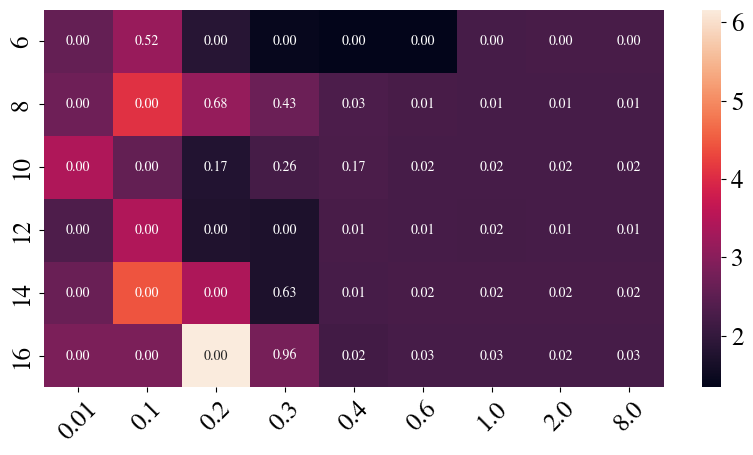

In [44]:
print(_ress2opt(ress))
# show the err mat
ress_mat = np.zeros((len(paras.can_Ns), len(paras.can_lams_trunc)));
pvals_mat = np.zeros((len(paras.can_Ns), len(paras.can_lams_trunc)));
for res in ress:
    row_ix = paras.can_Ns.index(res.para[2])
    col_ix = paras.can_lams_trunc.index(res.para[1])
    ress_mat[row_ix, col_ix] = res.mse
    pvals_mat[row_ix, col_ix] = np.round(res.pvals[0], 6)
    
min_idx = _get_min_mat_idx(ress_mat)
if True:
    sns.heatmap(ress_mat, annot=pvals_mat, fmt='.2f',  annot_kws={"size": 10})
    plt.yticks(np.arange(ress_mat.shape[0])+0.5, paras.can_Ns)
    plt.xticks(np.arange(ress_mat.shape[1])+0.5, paras.can_lams_trunc, rotation=45);

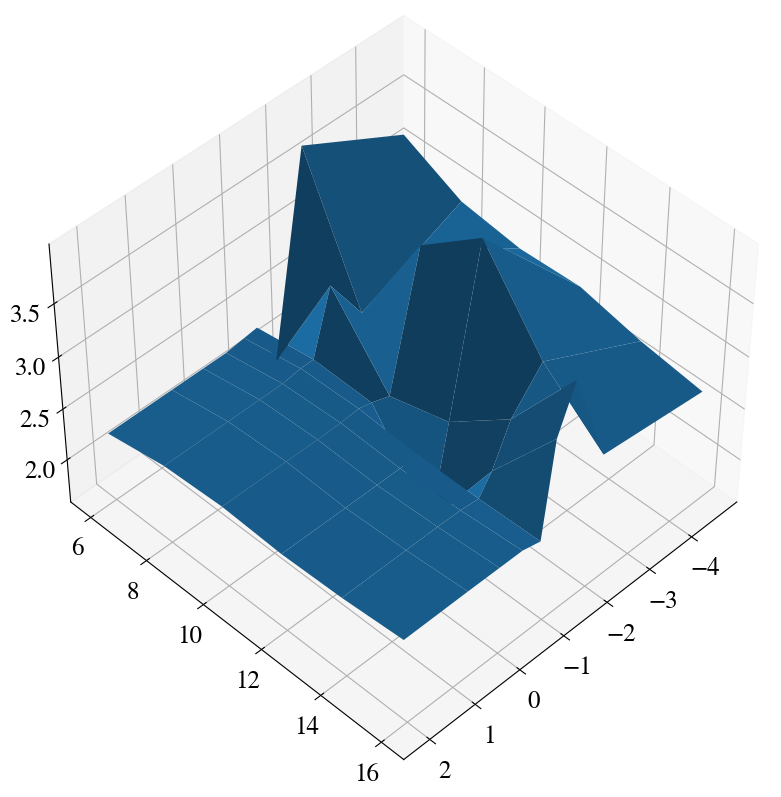

In [41]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(np.log(paras.can_lams), paras.can_Ns)

Z = ress_mat

# 绘制曲面
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45, azim=45)
ax.plot_surface(X, Y, Z)

In [30]:
for res in ress:
    if res.pvals[0] < 0.05:
        print(res)

{'mse': 3.5098316044714197, 'pvals': [1.2027411092110033e-13], 'mae': 1.445368052366284, 'para': [1.0, 0.01, 6.0], 'T_vs': [72.58850603988589]}
{'mse': 3.885768662364183, 'pvals': [0.0], 'mae': 1.5856026219348098, 'para': [1.0, 0.01, 8.0], 'T_vs': [2011.4209202070015]}
{'mse': 3.6999790804056447, 'pvals': [0.0], 'mae': 1.5475219403348341, 'para': [1.0, 0.01, 10.0], 'T_vs': [13417797.643094033]}
{'mse': 3.4604772471082135, 'pvals': [0.0], 'mae': 1.527034075019321, 'para': [1.0, 0.01, 12.0], 'T_vs': [770198261708.1482]}
{'mse': 3.072504607252922, 'pvals': [0.0], 'mae': 1.3969772259108297, 'para': [1.0, 0.01, 14.0], 'T_vs': [1833809615652.0325]}
{'mse': 3.3906062156060397, 'pvals': [0.0], 'mae': 1.4484751978111894, 'para': [1.0, 0.01, 16.0], 'T_vs': [16359350484283.729]}
{'mse': 2.9966612495133176, 'pvals': [0.00013329899248127315], 'mae': 1.3591702405926633, 'para': [1.0, 0.1, 8.0], 'T_vs': [31.128394000697906]}
{'mse': 4.718130212423139, 'pvals': [3.179847282732057e-20], 'mae': 1.740105

In [10]:
cur_fil = list(paras.res_dir.glob(f"seed_{1:.0f}-lam_1350-N_14.pkl"))[0]
res1 = load_pkl(cur_fil);
cur_fil = list(paras.res_dir.glob(f"seed_{1:.0f}-lam_507-N_14.pkl"))[0]
res2 = load_pkl(cur_fil);

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_sim-setting1/seed_1-lam_1350-N_14.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../results/simu_linear_sinica_sim-setting1/seed_1-lam_507-N_14.pkl


In [21]:
res1.T_vs

[8024.846108843493, 72.34890675064463, 5079.431812508514]

In [11]:
b1 = res1.paras.basis_mats[-2] @ res1.est_Gam;
b2 = res2.paras.basis_mats[-2] @ res2.est_Gam;

In [12]:
torch.norm(b1[:, 0] - b1[:, 1]), torch.norm(b2[:, 0] - b2[:, 1])

(tensor(10.2256), tensor(16.2430))

In [13]:
torch.norm(b1 - res1.paras.beta_GT, dim=0)

tensor([ 7.4680,  5.1938,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, 10.0695, 10.0231])

In [14]:
torch.norm(b2 - res1.paras.beta_GT, dim=0)

tensor([12.1175,  9.1233, 12.4101, 12.9477, 14.6447, 10.5957, 10.2252, 10.3605,
        10.8706, 10.3829,  8.0290, 13.4645, 10.8530, 10.2792, 11.0340, 10.3546,
         8.6958, 14.5927, 13.3931, 16.5272])

In [15]:
res1.est_alp,  res2.est_alp

(tensor([0.0353]), tensor([0.4361]))

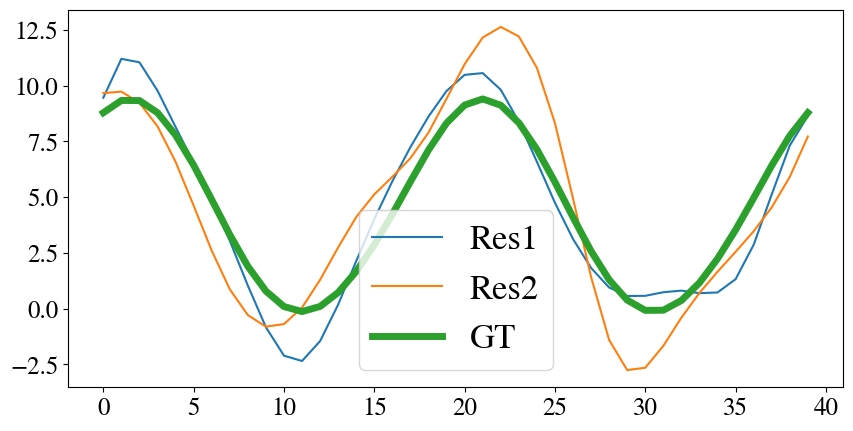

In [18]:
idx = 0
plt.plot(b1[:, idx], label="Res1")
plt.plot(b2[:, idx], label="Res2")
plt.plot(res1.paras.beta_GT[:, idx], lw=5, label="GT")
plt.legend()

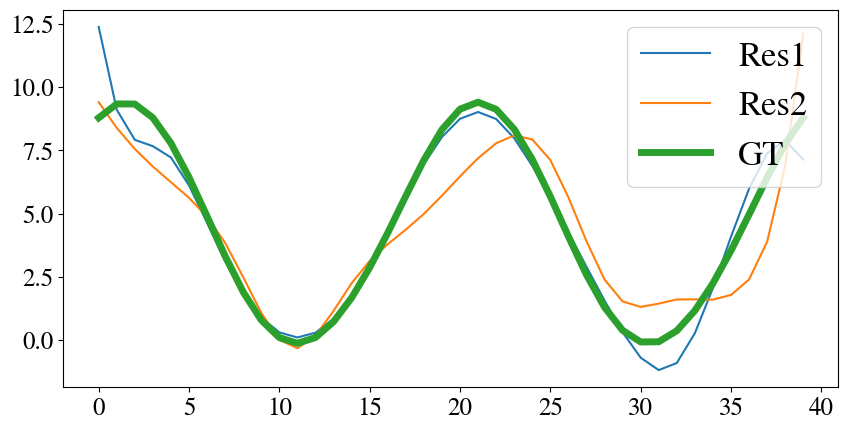

In [17]:
idx = 1
plt.plot(b1[:, idx], label="Res1")
plt.plot(b2[:, idx], label="Res2")
plt.plot(res1.paras.beta_GT[:, idx], lw=5, label="GT")
plt.legend()

#  Check

In [106]:
paras.can_Ns = [4, 6, 8, 10, 12, 14, 16]

In [121]:
# optimal N and lam
c1 = 0.0
c1_fct = 1000
print("The power/type I error under optimal N and lams")
fil = list(paras.res_dir.glob(f"allseeds*-c1_{c1*c1_fct:.0f}.pkl"))[0]
res_paras = load_pkl(fil, verbose=False).paras;

all_ress = []
for N in paras.can_Ns:
    fil = list(paras.res_dir.glob(f"allseeds*-N_{N:.0f}-c1_{c1*c1_fct:.0f}.pkl"))[0]
    res = load_pkl(fil, verbose=False)
    res_lam_fixN = [_get_optlam_fixN(tmp) for tmp in res.all_res]
    all_ress.append(res_lam_fixN)
    
all_errss =  ddict(lambda : np.zeros(len(paras.can_Ns), dtype=float)-1);
all_pvalss =  ddict(lambda : np.zeros(len(paras.can_Ns), dtype=float)-1);
all_optlams =  ddict(lambda : np.zeros(len(paras.can_Ns), dtype=float)-1);
all_Tvs =  ddict(lambda : np.zeros(len(paras.can_Ns), dtype=float)-1);
for idx, all_res in enumerate(all_ress):
    for res in all_res:
        all_errss[int(res.seed)][idx] = _err_fn(res.cv_errs)
        all_pvalss[int(res.seed)][idx] = res.pvals[0]
        all_optlams[int(res.seed)][idx] = res.lam
        all_Tvs[int(res.seed)][idx] = res.T_vs[0]
        
# get error and pval under optimal N and lam.
opt_errs = []
opt_pvals = []
opt_Tvs = []
opt_Ns = []
opt_lams = []
for k, v  in all_errss.items():
    #if k >= 200:
    #    continue
    pvals = all_pvalss[k]
    Tvs = all_Tvs[k]
    if np.sum(v==-1)==0:
        opt_errs.append(np.min(v))
        opt_pvals.append(pvals[np.argmin(v)])
        opt_Tvs.append(Tvs[np.argmin(v)])
        opt_Ns.append(paras.can_Ns[np.argmin(v)])
        opt_lams.append(all_optlams[k][np.argmin(v)])
opt_pvals = np.array(opt_pvals)
opt_errs = np.array(opt_errs);
opt_Tvs = np.array(opt_Tvs)
opt_lams = np.array(opt_lams);
opt_Ns = np.array(opt_Ns);
    
#print(np.unique(opt_Ns, return_counts=1))
print(f"The power under c1={c1:.2f} and sample size {len(opt_errs):.0f} is {np.mean(opt_pvals < 0.05):.3f}.")
    

The power/type I error under optimal N and lams
The power under c1=0.00 and sample size 200 is 0.045.


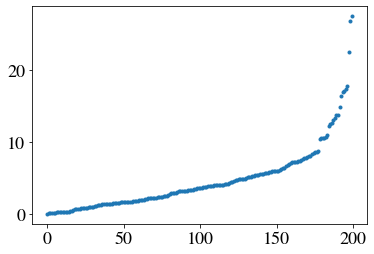

In [122]:
plt.plot(np.sort(opt_Tvs), ".")

In [123]:
np.sort(opt_Tvs)

array([2.42862957e-02, 9.02704795e-02, 9.72414270e-02, 2.01470198e-01,
       2.02041746e-01, 2.11806014e-01, 2.21110449e-01, 2.54875936e-01,
       2.76289609e-01, 2.92448223e-01, 2.94096473e-01, 3.04004698e-01,
       3.15302803e-01, 3.21777396e-01, 3.28611621e-01, 4.15499895e-01,
       4.34036933e-01, 5.89105293e-01, 6.51021138e-01, 6.54865893e-01,
       6.93786811e-01, 7.25437385e-01, 8.13901571e-01, 8.54251195e-01,
       8.56598614e-01, 8.70480350e-01, 9.04032880e-01, 9.24743255e-01,
       9.26516720e-01, 9.52722212e-01, 9.55610235e-01, 1.11375007e+00,
       1.13703864e+00, 1.21410869e+00, 1.27807188e+00, 1.28404333e+00,
       1.36907944e+00, 1.37303866e+00, 1.39125906e+00, 1.39491750e+00,
       1.41721220e+00, 1.44722143e+00, 1.47073694e+00, 1.47482641e+00,
       1.52794909e+00, 1.52813199e+00, 1.53785604e+00, 1.54344463e+00,
       1.61058039e+00, 1.61235717e+00, 1.63475110e+00, 1.66461901e+00,
       1.67472173e+00, 1.67630951e+00, 1.67867410e+00, 1.68022131e+00,
      

In [124]:
opt_pvals[opt_Tvs<0], opt_Ns[opt_Tvs<0],  opt_lams[opt_Tvs<0]

(array([], dtype=float64), array([], dtype=int64), array([], dtype=float64))

In [125]:
opt_lamNs = np.stack([opt_lams, opt_Ns]).T;
coms, cts  = np.unique(opt_lamNs, axis=0, return_counts=1);
opt_lam1, opt_N1 = coms[np.argmax(cts)]
fil = list(paras.res_dir.glob(f"allseeds*-N_{opt_N1:.0f}-c1_{c1*c1_fct:.0f}.pkl"))[0]
opt_res1 = load_pkl(fil, verbose=False);
opt_pvals1 = []
for tmp_res in opt_res1.all_res:
    opt_pvals1.append([tt.pvals[0] for tt in tmp_res if tt.lam==opt_lam1][0])
opt_pvals1 = np.array(opt_pvals1);
print(f"The power under c1={c1:.2f} and sample size {len(opt_errs):.0f} is {np.mean(opt_pvals1 < 0.05):.3f}.")

The power under c1=0.00 and sample size 200 is 0.040.


In [126]:
mat1 = np.zeros((len(paras.can_Ns), len(res_paras.can_lams)))
mat2 = np.zeros((len(paras.can_Ns), len(res_paras.can_lams)))
for lamN, pval in zip(opt_lamNs, opt_pvals):
    if pval >= 0.05:
        mat1[paras.can_Ns.index(lamN[1]), res_paras.can_lams.index(lamN[0])] += 1
    else:
        mat2[paras.can_Ns.index(lamN[1]), res_paras.can_lams.index(lamN[0])] += 1

In [127]:
# 43, 193, 144
np.where(opt_pvals<0.05), opt_pvals[opt_pvals<0.05]

((array([ 15,  36,  37,  61,  71,  97, 126, 170, 194]),),
 array([0.02315035, 0.01063595, 0.0080517 , 0.00249263, 0.03224931,
        0.01405097, 0.02918222, 0.00656515, 0.03149537]))

In [128]:
ttt = np.bitwise_and(opt_lams==0.01, opt_Ns==10)
opt_pvals[ttt], np.where(ttt)

(array([], dtype=float64), (array([], dtype=int64),))

Text(970.2, 0.5, 'N')

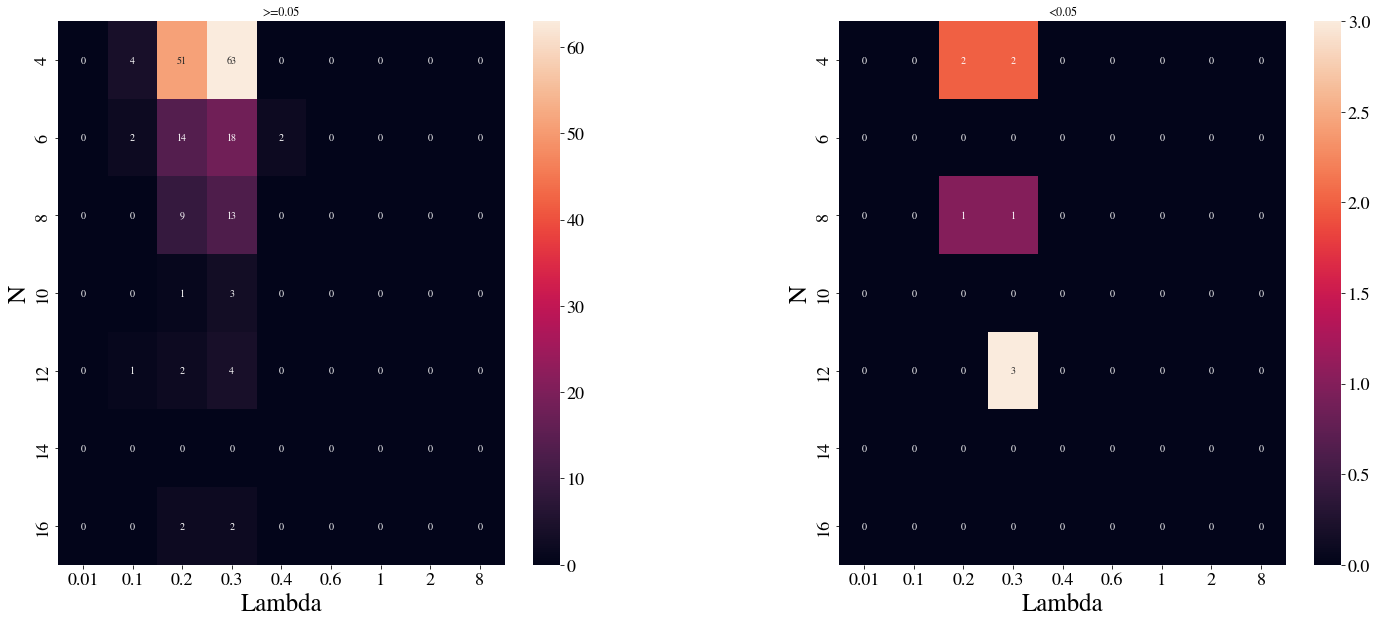

In [129]:
plt.figure(figsize=[24, 10])
plt.subplot(121)
plt.title(">=0.05")
sns.heatmap(mat1, annot=True)
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns);
plt.xticks(np.arange(len(res_paras.can_lams))+0.5, res_paras.can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")

plt.subplot(122)
plt.title("<0.05")
sns.heatmap(mat2, annot=True)
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns);
plt.xticks(np.arange(len(res_paras.can_lams))+0.5, res_paras.can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")

In [130]:
cur_seed = 3 #43
Tv_mats = []
for cur_seed in trange(30):
    err_mat = []
    pval_mat = []
    Tv_mat = []
    for cur_N in paras.can_Ns:
        tmp_fil = list(paras.res_dir.glob(f"allseeds*-N_{cur_N:.0f}-c1_{c1*c1_fct:.0f}.pkl"))[0]
        tmp_res = load_pkl(tmp_fil, verbose=0);
        
        err_mat.append([_err_fn(tt.cv_errs) for tt in tmp_res.all_res[cur_seed]])
        pval_mat.append([tt.pvals[0] for tt in tmp_res.all_res[cur_seed]])
        Tv_mat.append([tt.T_vs[0] for tt in tmp_res.all_res[cur_seed]])
    err_mat = np.array(err_mat)
    pval_mat = np.array(pval_mat);
    Tv_mat = np.array(Tv_mat);
    Tv_mats.append(Tv_mat)
Tv_mats = np.array(Tv_mats);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:23<00:00,  1.26it/s]


In [131]:
np.sum(Tv_mats<=0, axis=0)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0]])

In [132]:
err_mat[paras.can_Ns.index(8), res_paras.can_lams.index(0.3)], pval_mat[paras.can_Ns.index(8), res_paras.can_lams.index(0.3)]

(0.9477493312975157, 0.6853336675905001)

Text(970.2, 0.5, 'N')

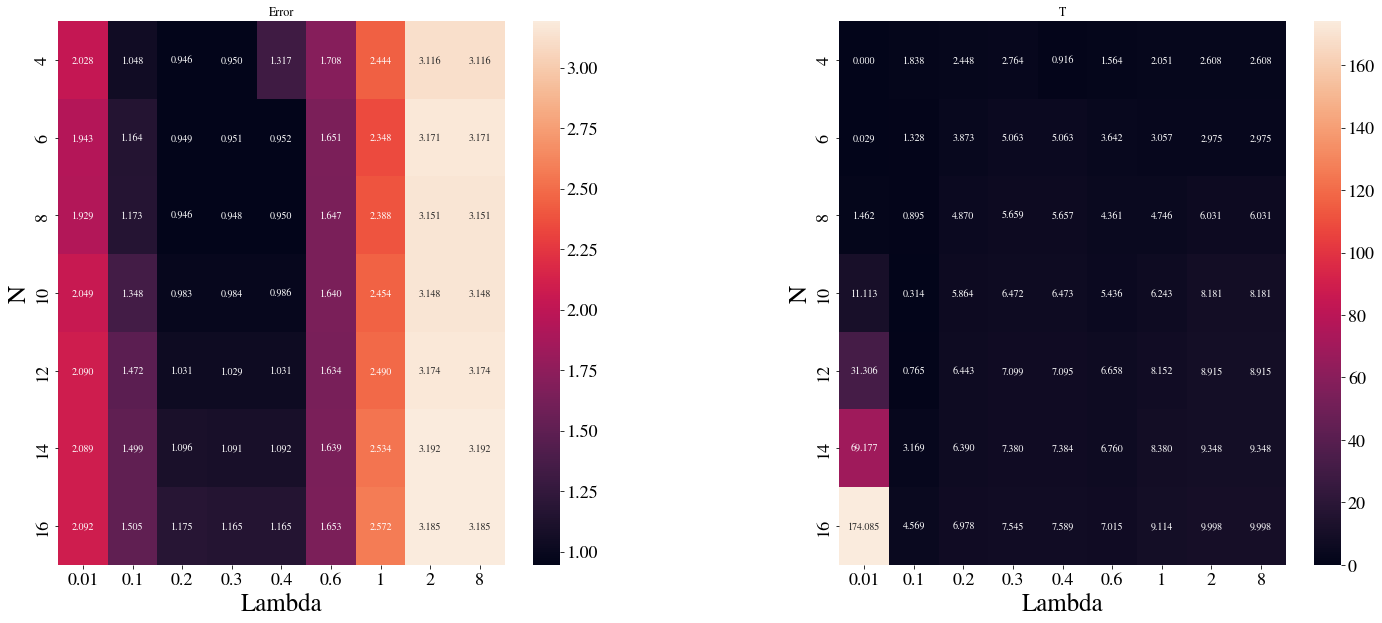

In [133]:
plt.figure(figsize=[24, 10])
plt.subplot(121)
plt.title("Error")
sns.heatmap(err_mat, annot=True, fmt=".3f")
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns);
plt.xticks(np.arange(len(res_paras.can_lams))+0.5, res_paras.can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")

plt.subplot(122)
if 0:
    plt.title("Pval")
    sns.heatmap(pval_mat, annot=True)

else:
    plt.title("T")
    sns.heatmap(Tv_mat, annot=True, fmt=".3f")
plt.yticks(np.arange(len(paras.can_Ns))+0.5, paras.can_Ns);
plt.xticks(np.arange(len(res_paras.can_lams))+0.5, res_paras.can_lams);
plt.xlabel("Lambda")
plt.ylabel("N")